In [55]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [56]:
# Importacion de datos de entrenamiento
df = pd.read_excel('data_entrenada_propia_GP.ods', engine='odf')
df

,Unnamed: 0,feedback,codigo,polaridad,Unnamed: 4
0,624927,"muy bien elaborada, se podría incluir ciertos ...",624927,P,NaN
1,543337,La información es ordenada y precisa pero reco...,543337,P,NaN
2,614284,Excelente aporte,614284,P,NaN
3,296130,"En la respuesta que le he puesto 3, ha sido po...",296130,N,NaN
4,555037,"Conciso, excelente",555037,P,NaN
...,...,...,...,...,...
2995,684953,excelente,684953,P,NaN
2996,444203,"Felicidades estimado/a estudiante, excelente t...",444203,P,NaN
2997,666824,Me gusto su presentación,666824,P,NaN
2998,167032,Se entiende en la formulacion de la encuesta q...,167032,P,NaN


In [57]:
df2 = pd.read_csv('Dataset_de_Pruebas_Extendido.csv')
df2

,feedback,polaridad
0,"La experiencia fue excelente, muy recomendada",P
1,"Nunca recibí lo que pedí, pésimo servicio",N
2,No tengo nada relevante que mencionar,NEU
3,Definitivamente lo volvería a comprar,P
4,El paquete estaba incompleto y defectuoso,N
...,...,...
2996,"La experiencia fue regular, ni buena ni mala",NEU
2997,El equipo funciona perfectamente,P
2998,La atención fue deficiente y no cumplieron lo ...,N
2999,"Podría ser mejor, pero no es terrible",NEU


# Limpieza de datos

In [58]:
print(df.isnull().sum())

Unnamed: 0       0
feedback         5
codigo           0
polaridad        7
Unnamed: 4    2792
dtype: int64


In [59]:
# Eliminar filas con valores nulos en 'feedback' o 'polaridad'
df = df.dropna(subset=['feedback', 'polaridad'])

In [60]:
# Verificar que los valores nulos se eliminaron
print(df.isnull().sum())

Unnamed: 0       0
feedback         0
codigo           0
polaridad        0
Unnamed: 4    2780
dtype: int64


In [61]:
# DataFrame solo con las columnas necesarias
df = df[['polaridad', 'feedback']]

In [62]:
# Revision de la columna 'polaridad'
print(df['polaridad'].value_counts())

polaridad
P         1780
N          552
NEU        330
NONE       322
NUE          2
NEUTRO       1
NOE          1
Name: count, dtype: int64


In [63]:
# Normalizar los nombres de la polaridad
df.loc[(df['polaridad'] == 'NEUTRO') | (df['polaridad'] == 'NUE') | (df['polaridad'] == 'NOE')]

,polaridad,feedback
68,NEUTRO,Muy Bien
253,NUE,Hay variedad de plantas que son medicinales de...
1331,NOE,10 puntos.
1446,NUE,Muy narrativa


In [64]:
# Cambiar valores incorrectos
df.loc[:, 'polaridad'] = df['polaridad'].replace({
    'NEUTRO': 'P',
    'NOE': 'NONE',
    'NUE': 'NEU'
})

In [65]:
# Revision de los cambios en la columna 'polaridad'
print(df['polaridad'].value_counts())

polaridad
P       1781
N        552
NEU      332
NONE     323
Name: count, dtype: int64


In [66]:
df['feedback'] = df['feedback'].astype(str)

In [67]:
df.head()

,polaridad,feedback
0,P,"muy bien elaborada, se podría incluir ciertos ..."
1,P,La información es ordenada y precisa pero reco...
2,P,Excelente aporte
3,N,"En la respuesta que le he puesto 3, ha sido po..."
4,P,"Conciso, excelente"


In [68]:
# Eliminar los datos NONE que no tienen ningun valor
df = df[df['polaridad'] != 'NONE']

In [69]:
# Concatenar los datasets por filas
df = pd.concat([df, df2], ignore_index=True)

# Mostrar el resultado
df

,polaridad,feedback
0,P,"muy bien elaborada, se podría incluir ciertos ..."
1,P,La información es ordenada y precisa pero reco...
2,P,Excelente aporte
3,N,"En la respuesta que le he puesto 3, ha sido po..."
4,P,"Conciso, excelente"
...,...,...
5661,NEU,"La experiencia fue regular, ni buena ni mala"
5662,P,El equipo funciona perfectamente
5663,N,La atención fue deficiente y no cumplieron lo ...
5664,NEU,"Podría ser mejor, pero no es terrible"


<Axes: >

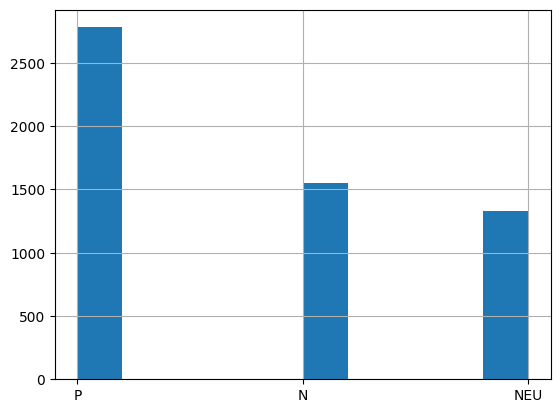

In [70]:
df['polaridad'].hist()

In [71]:
# Crear codigos para cada polaridad
target_map = {'P': 1, 'N': 0, 'NEU': 2}
df['target'] = df['polaridad'].map(target_map)

In [72]:
df

,polaridad,feedback,target
0,P,"muy bien elaborada, se podría incluir ciertos ...",1
1,P,La información es ordenada y precisa pero reco...,1
2,P,Excelente aporte,1
3,N,"En la respuesta que le he puesto 3, ha sido po...",0
4,P,"Conciso, excelente",1
...,...,...,...
5661,NEU,"La experiencia fue regular, ni buena ni mala",2
5662,P,El equipo funciona perfectamente,1
5663,N,La atención fue deficiente y no cumplieron lo ...,0
5664,NEU,"Podría ser mejor, pero no es terrible",2


# Entrenamiento del Modelo

In [73]:
# Division de datos para entrenamiento y prueba
df_train, df_test = train_test_split(df, test_size=0.4)

In [74]:
df_train

,polaridad,feedback,target
2117,P,buen trabajo,1
2334,P,Muy buen trabajo falta el desarrollo de la dis...,1
924,NEU,Cumple facetas exigidas.,2
832,P,Buen trabajo.,1
3208,P,El servicio fue rápido y eficiente,1
...,...,...,...
168,NEU,Detallar más la solución del el caso,2
951,NEU,El reto no pedìa incluir un soporte de informa...,2
1995,N,"Saludos,En la pregunta que hace referencia a l...",0
4402,P,El servicio fue rápido y eficiente,1


In [75]:
df_test

,polaridad,feedback,target
2538,P,Excelente,1
55,NEU,Considero que pudo haber contestado más preguntas,2
2968,P,"La experiencia fue excelente, muy recomendada",1
3822,NEU,La calidad es buena pero podría mejorar,2
3706,P,"El producto cumplió las expectativas, aunque n...",1
...,...,...,...
1938,N,"TODAS LAS ORACIONES, NO ESTÁN EN FUNCIÓN DEL L...",0
4247,N,El producto llegó tarde y en mal estado,0
947,P,Buen trabajo el huerto casero nos permite la p...,1
781,P,Su calificación es de:15/15,1


In [76]:
# Vectorizacion de palabras con un maximo de 1400
vectorizer = TfidfVectorizer(max_features=1368)

In [77]:
X_train = vectorizer.fit_transform(df_train['feedback'])
X_train

<3399x1368 sparse matrix of type '<class 'numpy.float64'>'
	with 23213 stored elements in Compressed Sparse Row format>

In [78]:
X_test = vectorizer.fit_transform(df_test['feedback'])
X_test

<2267x1368 sparse matrix of type '<class 'numpy.float64'>'
	with 15880 stored elements in Compressed Sparse Row format>

In [79]:
y_train = df_train['polaridad']
y_test = df_test['polaridad']

In [80]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print("Train acc: ", model.score(X_train, y_train))
print("Test acc: ", model.score(X_test, y_test))

Train acc:  0.9514563106796117
Test acc:  0.45081605646228495


In [81]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

In [82]:
cm = confusion_matrix(y_train, P_train, normalize='true')
cm

array([[0.95637584, 0.01006711, 0.03355705],
       [0.06071871, 0.86369269, 0.0755886 ],
       [0.00471143, 0.00471143, 0.99057715]])

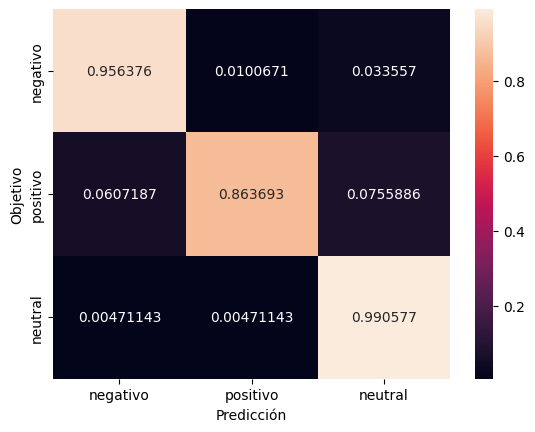

In [83]:
def plot_cm(cm):
    classes = ['negativo', 'positivo', 'neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Objetivo")

plot_cm(cm)

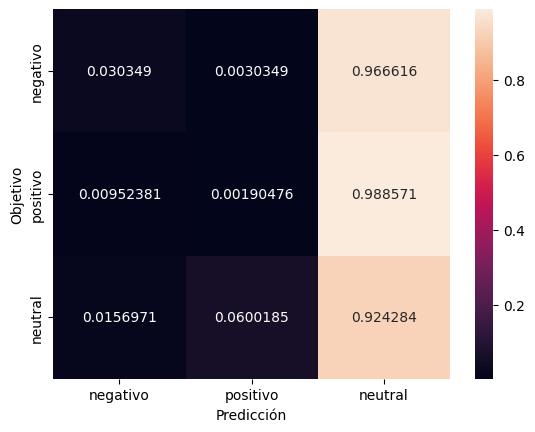

In [84]:
cm = confusion_matrix(y_test, P_test, normalize='true')
plot_cm(cm)

In [30]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'excelente': 447,
 'trabajo': 1243,
 'éxitos': 1366,
 'en': 388,
 'este': 431,
 'curso': 293,
 'perfecto': 775,
 'el': 377,
 'diseño': 363,
 'de': 301,
 'la': 563,
 'infografia': 542,
 'es': 407,
 'llamativa': 579,
 'bien': 77,
 'ordenada': 713,
 'que': 939,
 'motiva': 617,
 'leer': 570,
 'su': 1154,
 'contenido': 224,
 'buena': 81,
 'presentacion': 866,
 'felicidades': 471,
 'compañero': 138,
 'saludos': 1074,
 'del': 316,
 'tena': 1201,
 'verdad': 1320,
 'un': 1273,
 'buen': 80,
 'se': 1078,
 'merece': 604,
 'esa': 408,
 'calificación': 89,
 'porque': 835,
 'fue': 485,
 'una': 1274,
 'las': 566,
 'principales': 881,
 'comunidad': 166,
 'comunicativa': 165,
 'no': 657,
 'puede': 923,
 'ver': 1319,
 'debido': 308,
 'calidad': 88,
 'imagen': 528,
 'revisar': 1051,
 'por': 832,
 'favor': 470,
 'me': 597,
 'gusto': 497,
 'mucho': 623,
 'como': 129,
 'ha': 499,
 'resumido': 1045,
 'los': 586,
 'aspectos': 58,
 'mas': 594,
 'microorganismos': 606,
 'concuerdo': 184,
 'con': 170,
 'te': 119

In [31]:
model.coef_[0]

array([ 0.20246882, -0.11033645, -0.17585563, ...,  0.32638359,
       -0.1526226 , -0.1997816 ])

In [32]:
corte = 0.8

print("Palabras más positivas:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > corte:
        print(word, weight)

Palabras más positivas:
información 1.770941926369859
personas 4.235671709207172
inicio 0.8361334683285024
negativa 0.974922054736559
entrega 0.9065437821932535
mucha 0.981234782696943
diferentes 1.039344424526437
notable 0.9045053052097572


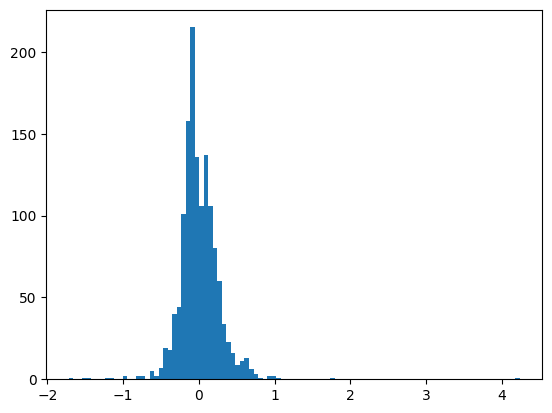

In [33]:
plt.hist(model.coef_[0], bins=100);

In [34]:
corte = 0.7

print("Palabras más positivas:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -corte:
        print(word, weight)

Palabras más positivas:
usted -0.762890722420872
empresa -0.8110654682444964
combinación -1.508809879311905
compita -1.1292994785226682
investigar -0.7991743038679979
competo -1.4623857310981594
humorsé -1.718957750153572
png -0.9738911652091224
utilizan -0.7320032807617798
percibir -1.1851883177957894
ja -0.9980147982557914


In [35]:
# Prueba del modelo entrenado
prueba = ["Estuvo muy buena la pelicula", "estuvo terrible la pelicula, me aburrí mucho", "no la recomiendo", "Vi la pelicula"]

In [ ]:
# Transformar la entrada con el vectorizador
X = vectorizer.transform(prueba)

# Predecir con el modelo
P = model.predict(X)

# Obtener las clases del modelo
clases = model.classes_

print(f"Longitud de P: {len(P)}")
print(f"Longitud de clases: {len(clases)}")

for i in range(len(prueba)):
    if i < len(clases) and i < len(P):  # Verificación de los límites
        if isinstance(P[i], int) and 0 <= P[i] < len(clases):  # Asegurar que P[i] es un índice válido
            if clases[P[i]] == 0:
                print(f"El comentario: '{prueba[i]}' es Negativo")
            else:
                print(f"El comentario: '{prueba[i]}' es Positivo")
        else:
            print(f"Índice inválido en P[{i}]: {P[i]}")